# Tokyo House price 
## 1. Load data

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Set random seed
seed = 22
np.random.seed(seed)
random.seed(seed)

# prevent auto line wrapping
pd.set_option('display.expand_frame_repr', False)  

file_path = 'kanto_house_price_with_indicators.csv'  
data = pd.read_csv(file_path)

In [2]:
# drop the column "GDPGrowth" and "NetMigration"
data = data.drop(columns=['GDPGrowth', 'NetMigration'])

In [3]:
data.rename(columns={
    'TotalTransactionValue': 'TransactionValue',
    'TotalFloorArea': 'FloorArea',
    'RegionCommercialArea': 'CommercialArea',
    'RegionIndustrialArea': 'IndustrialArea',
    'RegionPotentialResidentialArea': 'PotentialResidentialArea',
    'RegionResidentialArea': 'ResidentialArea',
    'Migration': 'Immigration'
}, inplace=True)

## 2. EDA
### 2.1 Data Overview

In [4]:
data = data[(data["Prefecture"]== 'Tokyo')]

In [5]:
print("data info:")
print(data.info())
print("\ndata head:")
print(data.head())
print("\ndata distribution:")
print(data.describe())
print("\n Year count:")
print(data['Year'].value_counts())

data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 85109 entries, 107353 to 192461
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Prefecture                85109 non-null  object 
 1   TransactionValue          85109 non-null  int64  
 2   Area                      85109 non-null  int64  
 3   Frontage                  85109 non-null  float64
 4   FloorArea                 85109 non-null  int64  
 5   ConstructionYear          85109 non-null  int64  
 6   BuildingCoverageRatio     85109 non-null  float64
 7   FloorAreaRatio            85109 non-null  float64
 8   Year                      85109 non-null  int64  
 9   CommercialArea            85109 non-null  bool   
 10  IndustrialArea            85109 non-null  bool   
 11  PotentialResidentialArea  85109 non-null  bool   
 12  ResidentialArea           85109 non-null  bool   
 13  MunicipalityCategory      85109 non-null  in

In [6]:
data = data.drop(columns=['Prefecture'])

In [7]:
# reserve numeric variables
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].round(2)

In [8]:
pd.set_option('display.float_format', '{:.2f}'.format)
data.describe()

,TransactionValue,Area,Frontage,FloorArea,ConstructionYear,BuildingCoverageRatio,FloorAreaRatio,Year,MunicipalityCategory,AverageTimeToStation,Immigration,InflationRate,GDPPerCapita,Population,UnemploymentRate,OldAgeDependencyRatio
count,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00,85109.00
mean,75847091.38,126.27,8.30,134.86,2006.00,54.66,169.48,2018.47,3.59,13.68,58668.41,1.02,4306123.78,126365341.05,2.87,47.65
std,194985293.76,120.84,4.71,177.38,17.29,11.74,96.98,2.84,0.50,11.18,36579.98,1.20,90893.01,869928.98,0.37,2.28
min,100000.00,25.00,0.70,10.00,1945.00,30.00,50.00,2014.00,2.00,0.00,444.00,-0.23,4162329.52,124516650.00,2.35,43.13
25%,34000000.00,75.00,5.40,85.00,1994.00,40.00,80.00,2016.00,3.00,7.00,26819.00,-0.02,4231776.53,125681593.00,2.60,46.03
50%,47000000.00,105.00,7.50,95.00,2015.00,60.00,150.00,2019.00,4.00,11.00,53935.00,0.48,4321447.75,126633000.00,2.82,48.52
75%,66000000.00,130.00,10.00,110.00,2019.00,60.00,200.00,2021.00,4.00,16.00,87628.00,2.50,4374353.04,127076000.00,3.13,49.74
max,31000000000.00,2000.00,50.00,2000.00,2025.00,80.00,1000.00,2023.00,4.00,120.00,155340.00,3.27,4477458.47,127276000.00,3.59,50.28


In [9]:
data.columns

Index(['TransactionValue', 'Area', 'Frontage', 'FloorArea', 'ConstructionYear',
       'BuildingCoverageRatio', 'FloorAreaRatio', 'Year', 'CommercialArea',
       'IndustrialArea', 'PotentialResidentialArea', 'ResidentialArea',
       'MunicipalityCategory', 'AverageTimeToStation', 'BeforeWarFlag',
       'Immigration', 'InflationRate', 'GDPPerCapita', 'Population',
       'UnemploymentRate', 'OldAgeDependencyRatio'],
      dtype='object')

In [10]:
categorical_var = ['ConstructionYear', 'Year', 'CommercialArea',
       'IndustrialArea', 'PotentialResidentialArea', 'ResidentialArea', 'MunicipalityCategory', 'BeforeWarFlag']

bool_var = ['CommercialArea', 'IndustrialArea', 'PotentialResidentialArea', 'ResidentialArea', 'MunicipalityCategory', 'BeforeWarFlag']

continuous_cols = ['Area', 'Frontage', 'FloorArea', 'BuildingCoverageRatio', 'FloorAreaRatio', 
                   'AverageTimeToStation', 'Immigration','InflationRate', 'GDPPerCapita',
                   'Population', 'UnemploymentRate',  'OldAgeDependencyRatio']

In [11]:
for var in categorical_var:
    print(data[var].value_counts())
    print("\n")

2020    5757
2014    5465
2015    5253
2016    5209
2021    5085
        ... 
1948      18
1949      17
1947      15
1946       4
2025       1
Name: ConstructionYear, Length: 81, dtype: int64


2020    9927
2021    9708
2015    9028
2016    8575
2014    8332
2017    8163
2018    8129
2019    7864
2022    7805
2023    7578
Name: Year, dtype: int64


False    80641
True      4468
Name: CommercialArea, dtype: int64


False    85009
True       100
Name: IndustrialArea, dtype: int64


False    85107
True         2
Name: PotentialResidentialArea, dtype: int64


True     80539
False     4570
Name: ResidentialArea, dtype: int64


4    50375
3    34358
2      376
Name: MunicipalityCategory, dtype: int64


False    85046
True        63
Name: BeforeWarFlag, dtype: int64




### 2.2 Target Variable Analysis

In [12]:
# find the lower outlier
data[data['TransactionValue'] < 1e5] 

,TransactionValue,Area,Frontage,FloorArea,ConstructionYear,BuildingCoverageRatio,FloorAreaRatio,Year,CommercialArea,IndustrialArea,...,ResidentialArea,MunicipalityCategory,AverageTimeToStation,BeforeWarFlag,Immigration,InflationRate,GDPPerCapita,Population,UnemploymentRate,OldAgeDependencyRatio


In [13]:
# show all the columns
pd.set_option('display.max_columns', None)
data_sorted = data.sort_values(by='TransactionValue', ascending=True)
data_sorted.head(20)


,TransactionValue,Area,Frontage,FloorArea,ConstructionYear,BuildingCoverageRatio,FloorAreaRatio,Year,CommercialArea,IndustrialArea,PotentialResidentialArea,ResidentialArea,MunicipalityCategory,AverageTimeToStation,BeforeWarFlag,Immigration,InflationRate,GDPPerCapita,Population,UnemploymentRate,OldAgeDependencyRatio
166389,100000,65,7.00,70,1984,60.00,150.00,2017,False,False,False,True,3,45,False,9456.00,0.48,4340877.56,126972000.00,2.82,47.09
142509,100000,80,6.00,70,1976,50.00,100.00,2020,False,False,False,True,4,23,False,119503.00,-0.02,4194271.94,126261000.00,2.81,49.13
149314,200000,45,4.20,55,1965,80.00,200.00,2017,False,False,False,True,4,12,False,67575.00,0.48,4340877.56,126972000.00,2.82,47.09
160044,200000,70,11.70,15,1969,40.00,80.00,2018,False,False,False,True,3,105,False,46590.00,0.99,4374353.04,126811000.00,2.47,47.91
161251,400000,100,6.90,55,1972,40.00,80.00,2017,False,False,False,True,3,75,False,46411.00,0.48,4340877.56,126972000.00,2.82,47.09
158166,500000,300,28.40,60,1985,40.00,80.00,2020,False,False,False,True,3,75,False,54583.00,-0.02,4194271.94,126261000.00,2.81,49.13
135108,500000,50,6.20,50,1966,60.00,150.00,2014,False,False,False,True,4,14,False,51890.00,2.76,4162329.52,127276000.00,3.59,43.13
176866,500000,80,2.00,65,1984,60.00,200.00,2019,False,False,False,True,3,17,False,28747.00,0.47,4362884.76,126633000.00,2.35,48.52
172644,500000,165,11.00,55,1969,40.00,80.00,2020,False,False,False,True,3,45,False,38378.00,-0.02,4194271.94,126261000.00,2.81,49.13
161253,500000,170,3.00,90,1990,40.00,80.00,2017,False,False,False,True,3,75,False,46411.00,0.48,4340877.56,126972000.00,2.82,47.09


In [ ]:
# drop extreme small house price (<10000)
data = data[data['TransactionValue'] >= 10000]

In [15]:
# find the highest outlier
data[data['TransactionValue'] == data['TransactionValue'].max()]

,TransactionValue,Area,Frontage,FloorArea,ConstructionYear,BuildingCoverageRatio,FloorAreaRatio,Year,CommercialArea,IndustrialArea,PotentialResidentialArea,ResidentialArea,MunicipalityCategory,AverageTimeToStation,BeforeWarFlag,Immigration,InflationRate,GDPPerCapita,Population,UnemploymentRate,OldAgeDependencyRatio
109319,31000000000,810,28.00,2000,1986,80.00,600.00,2019,True,False,False,False,4,7,False,53958.00,0.47,4362884.76,126633000.00,2.35,48.52


In [16]:
# drop the highest outlier
data = data[data['TransactionValue'] < 31000000000]

In [17]:
data.describe()

,TransactionValue,Area,Frontage,FloorArea,ConstructionYear,BuildingCoverageRatio,FloorAreaRatio,Year,MunicipalityCategory,AverageTimeToStation,Immigration,InflationRate,GDPPerCapita,Population,UnemploymentRate,OldAgeDependencyRatio
count,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00,85108.00
mean,75483739.48,126.26,8.30,134.84,2006.00,54.66,169.47,2018.47,3.59,13.68,58668.46,1.02,4306123.12,126365337.91,2.87,47.65
std,163655424.46,120.82,4.71,177.27,17.29,11.73,96.97,2.84,0.50,11.18,36580.19,1.20,90893.34,869933.60,0.37,2.28
min,100000.00,25.00,0.70,10.00,1945.00,30.00,50.00,2014.00,2.00,0.00,444.00,-0.23,4162329.52,124516650.00,2.35,43.13
25%,34000000.00,75.00,5.40,85.00,1994.00,40.00,80.00,2016.00,3.00,7.00,26819.00,-0.02,4231776.53,125681593.00,2.60,46.03
50%,47000000.00,105.00,7.50,95.00,2015.00,60.00,150.00,2019.00,4.00,11.00,53935.00,0.48,4321447.75,126633000.00,2.82,48.52
75%,66000000.00,130.00,10.00,110.00,2019.00,60.00,200.00,2021.00,4.00,16.00,87628.00,2.50,4374353.04,127076000.00,3.13,49.74
max,11000000000.00,2000.00,50.00,2000.00,2025.00,80.00,1000.00,2023.00,4.00,120.00,155340.00,3.27,4477458.47,127276000.00,3.59,50.28


In [18]:
# check the 95% quantile value of TransactionValue
data['TransactionValue'].quantile(0.95)

200000000.0

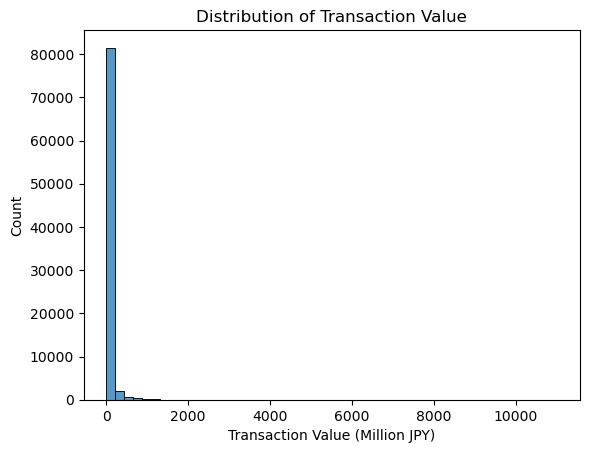

In [19]:
# change unit to million JPY
data['TransactionValue_Million'] = data['TransactionValue'] / 1e6

sns.histplot(data=data, x='TransactionValue_Million', bins=50)
plt.xlabel("Transaction Value (Million JPY)")
plt.title("Distribution of Transaction Value")
plt.show()

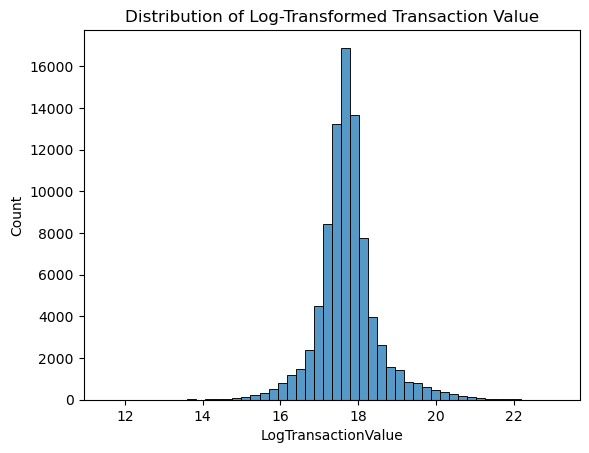

In [ ]:
# add new variable Log
data['LogTransactionValue'] = np.log(data['TransactionValue'])

sns.histplot(data['LogTransactionValue'], bins=50)
plt.title("Distribution of Log-Transformed Transaction Value")
plt.xlabel("LogTransactionValue")
plt.show()

In [21]:
print("Skewness:", data['LogTransactionValue'].skew()) 
print("Kurtosis:", data['LogTransactionValue'].kurt())

Skewness: 0.6285554020770237
Kurtosis: 4.033011296844476


In [22]:
summary_stats = data[['LogTransactionValue', 'TransactionValue']].describe()

print(summary_stats)

       LogTransactionValue  TransactionValue
count             85108.00          85108.00
mean                 17.71       75483739.48
std                   0.78      163655424.46
min                  11.51         100000.00
25%                  17.34       34000000.00
50%                  17.67       47000000.00
75%                  18.01       66000000.00
max                  23.12    11000000000.00


### 2.3 Correlation Analysis

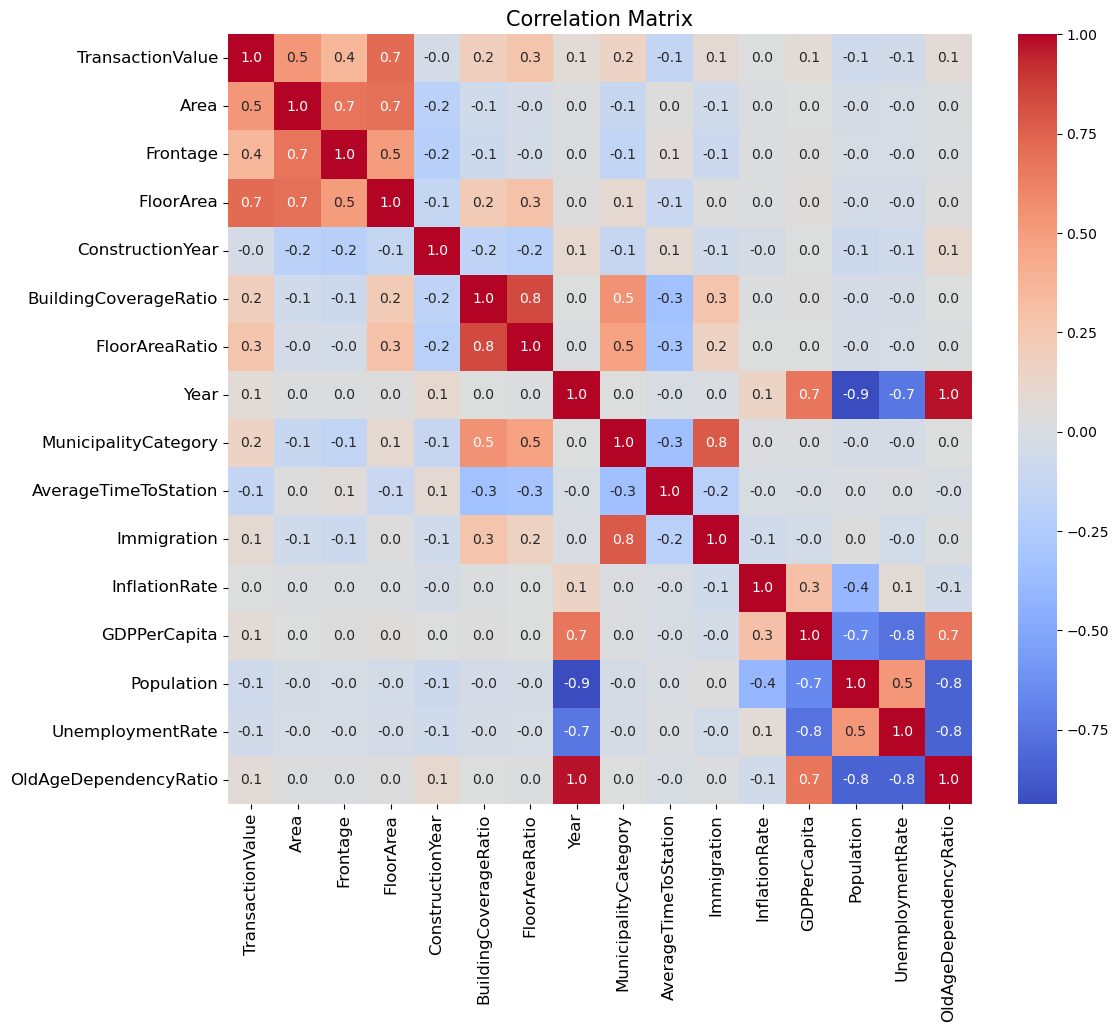

In [23]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
cols_to_exclude = ['LogTransactionValue', 'TransactionValue_Million']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

correlation = data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".1f", cmap='coolwarm')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Correlation Matrix', fontsize=15)
plt.show()

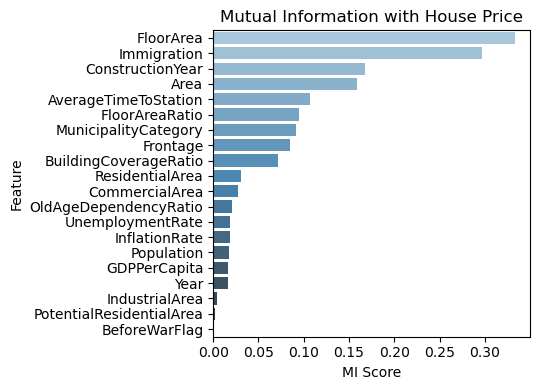

In [24]:
exclude_cols = ['TransactionValue', 'LogTransactionValue', 'TransactionValue_Million']

feature_cols = [col for col in data.select_dtypes(include=['float64', 'int64', 'bool', 'uint8']).columns if col not in exclude_cols]
X = data[feature_cols]

# target variable
y_raw = data['TransactionValue']

# calculate MI
mi_raw = mutual_info_regression(X, y_raw, random_state=0)

mi_df = pd.DataFrame({
    'Feature': feature_cols,
    'MI with Raw Target': mi_raw
}).sort_values(by='MI with Raw Target', ascending=False)

# visulisation
plt.figure(figsize=(5.5, 4))
sns.barplot(x='MI with Raw Target', y='Feature', data=mi_df, palette='Blues_d')
plt.title('Mutual Information with House Price')
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [25]:
# change to the categorical label
data['MunicipalityCategoryLabel'] = data['MunicipalityCategory'].map({
    1: 'Village',
    2: 'Town',
    3: 'City',
    4: 'Capital City'
})

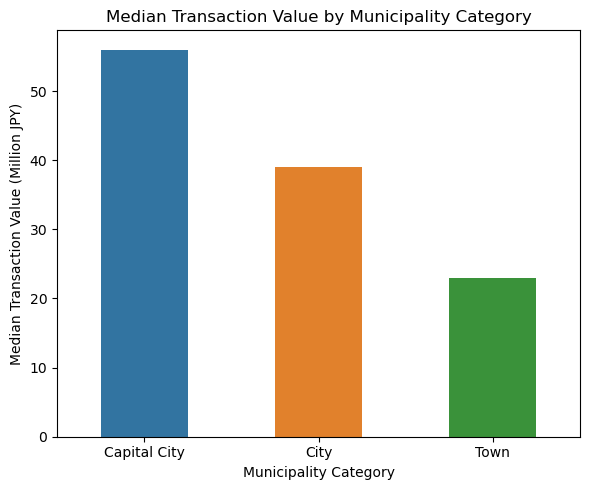

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# add the average house price
avg_price = data.groupby('MunicipalityCategoryLabel')['TransactionValue_Million'].median().reset_index()


plt.figure(figsize=(6, 5))
sns.barplot(x='MunicipalityCategoryLabel', y='TransactionValue_Million', width=0.5, data=avg_price)

plt.xlabel('Municipality Category')
plt.ylabel('Median Transaction Value (Million JPY)')
plt.title('Median Transaction Value by Municipality Category')
plt.tight_layout()
plt.show()

In [27]:
vars_to_plot = [
    'InflationRate', 'NetMigration', 'GDPPerCapita', 'Population',
    'UnemploymentRate', 'GDPGrowth', 'OldAgeDependencyRatio'
]

# economic & demographic features
macro_vars = ['InflationRate', 'GDPPerCapita', 'UnemploymentRate', 'Population', 'OldAgeDependencyRatio']

In [28]:
data = data.drop(columns=['MunicipalityCategory'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85108 entries, 107353 to 192461
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TransactionValue           85108 non-null  int64  
 1   Area                       85108 non-null  int64  
 2   Frontage                   85108 non-null  float64
 3   FloorArea                  85108 non-null  int64  
 4   ConstructionYear           85108 non-null  int64  
 5   BuildingCoverageRatio      85108 non-null  float64
 6   FloorAreaRatio             85108 non-null  float64
 7   Year                       85108 non-null  int64  
 8   CommercialArea             85108 non-null  bool   
 9   IndustrialArea             85108 non-null  bool   
 10  PotentialResidentialArea   85108 non-null  bool   
 11  ResidentialArea            85108 non-null  bool   
 12  AverageTimeToStation       85108 non-null  int64  
 13  BeforeWarFlag              85108 non-nul

In [29]:
data = pd.get_dummies(data, columns=['MunicipalityCategoryLabel'], drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85108 entries, 107353 to 192461
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TransactionValue                85108 non-null  int64  
 1   Area                            85108 non-null  int64  
 2   Frontage                        85108 non-null  float64
 3   FloorArea                       85108 non-null  int64  
 4   ConstructionYear                85108 non-null  int64  
 5   BuildingCoverageRatio           85108 non-null  float64
 6   FloorAreaRatio                  85108 non-null  float64
 7   Year                            85108 non-null  int64  
 8   CommercialArea                  85108 non-null  bool   
 9   IndustrialArea                  85108 non-null  bool   
 10  PotentialResidentialArea        85108 non-null  bool   
 11  ResidentialArea                 85108 non-null  bool   
 12  AverageTimeToStation      

# 3. Modelling & Hyperparameter Optimisation

In [ ]:
X = data.drop(columns=['TransactionValue_Million', 'LogTransactionValue', 'TransactionValue', 'BeforeWarFlag'])
y = data['LogTransactionValue']

# bool to int
bool_cols = ['CommercialArea', 'IndustrialArea', 'PotentialResidentialArea', 'ResidentialArea']
X[bool_cols] = X[bool_cols].astype(int)

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [31]:
X.columns

Index(['Area', 'Frontage', 'FloorArea', 'ConstructionYear',
       'BuildingCoverageRatio', 'FloorAreaRatio', 'Year', 'CommercialArea',
       'IndustrialArea', 'PotentialResidentialArea', 'ResidentialArea',
       'AverageTimeToStation', 'Immigration', 'InflationRate', 'GDPPerCapita',
       'Population', 'UnemploymentRate', 'OldAgeDependencyRatio',
       'MunicipalityCategoryLabel_City', 'MunicipalityCategoryLabel_Town'],
      dtype='object')

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

def train_with_gridsearch(name, model, param_grid, X_train, y_train):
    grid = GridSearchCV(
        model,
        param_grid,
        scoring=scoring,
        refit='neg_mse',  # RMSE as the primary metric
        cv=5,
        return_train_score=True,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    print(f"Best parameters for {name}: {grid.best_params_}")
    print("Cross-validated (CV) mean scores on training set for all parameter combinations:")
    
    # training metrics
    mean_train_r2 = grid.cv_results_['mean_train_r2']
    mean_train_neg_mse = grid.cv_results_['mean_train_neg_mse']
    mean_train_neg_mae = grid.cv_results_['mean_train_neg_mae']
    
    mean_test_r2 = grid.cv_results_['mean_test_r2']
    mean_test_neg_mse = grid.cv_results_['mean_test_neg_mse']
    mean_test_neg_mae = grid.cv_results_['mean_test_neg_mae']
    
    for i, params in enumerate(grid.cv_results_['params']):
        print(f"Params: {params}")
        print(f" - Train R²: {mean_train_r2[i]:.4f}")
        print(f" - Train RMSE: {np.sqrt(-mean_train_neg_mse[i]):.4f}")
        print(f" - Train MAE: {-mean_train_neg_mae[i]:.4f}")
        print(f" - CV R²: {mean_test_r2[i]:.4f}")
        print(f" - CV RMSE: {np.sqrt(-mean_test_neg_mse[i]):.4f}")
        print(f" - CV MAE: {-mean_test_neg_mae[i]:.4f}")
        print("-" * 30)

    best_idx = grid.best_index_
    print("Selected best parameters based on CV RMSE:")
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f" - CV R²: {mean_test_r2[best_idx]:.4f}")
    print(f" - CV RMSE: {np.sqrt(-mean_test_neg_mse[best_idx]):.4f}")
    print(f" - CV MAE: {-mean_test_neg_mae[best_idx]:.4f}")
    print(f" - Train R²: {mean_train_r2[best_idx]:.4f}")
    print(f" - Train RMSE: {np.sqrt(-mean_train_neg_mse[best_idx]):.4f}")
    print(f" - Train MAE: {-mean_train_neg_mae[best_idx]:.4f}")
    print()
    
    return grid.best_estimator_

## 3.1 Model 1. LR with Ridge

In [ ]:
# Model 1：Linear Regression with Ridge 
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
ridge_params = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10, 100]
}
ridge_best = train_with_gridsearch("Ridge Regression", ridge_pipeline, ridge_params, X_train, y_train)

Best parameters for Ridge Regression: {'ridge__alpha': 1.0}
Cross-validated (CV) mean scores on training set for all parameter combinations:
Params: {'ridge__alpha': 0.01}
 - Train R²: 0.6161
 - Train RMSE: 0.4835
 - Train MAE: 0.3407
 - CV R²: 0.6157
 - CV RMSE: 0.4838
 - CV MAE: 0.3409
------------------------------
Params: {'ridge__alpha': 0.1}
 - Train R²: 0.6161
 - Train RMSE: 0.4835
 - Train MAE: 0.3407
 - CV R²: 0.6157
 - CV RMSE: 0.4838
 - CV MAE: 0.3409
------------------------------
Params: {'ridge__alpha': 1.0}
 - Train R²: 0.6161
 - Train RMSE: 0.4835
 - Train MAE: 0.3407
 - CV R²: 0.6157
 - CV RMSE: 0.4838
 - CV MAE: 0.3409
------------------------------
Params: {'ridge__alpha': 10}
 - Train R²: 0.6161
 - Train RMSE: 0.4835
 - Train MAE: 0.3407
 - CV R²: 0.6157
 - CV RMSE: 0.4838
 - CV MAE: 0.3409
------------------------------
Params: {'ridge__alpha': 100}
 - Train R²: 0.6160
 - Train RMSE: 0.4836
 - Train MAE: 0.3407
 - CV R²: 0.6156
 - CV RMSE: 0.4838
 - CV MAE: 0.3409


## 3.2 Model 2. RF

In [ ]:
# Model 2：Random Forest
rf = RandomForestRegressor(random_state=22)
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5]
}
rf_best = train_with_gridsearch("Random Forest", rf, rf_params, X_train, y_train)

/Users/elise/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validated (CV) mean scores on training set for all parameter combinations:
Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
 - Train R²: 0.9600
 - Train RMSE: 0.1560
 - Train MAE: 0.0975
 - CV R²: 0.8321
 - CV RMSE: 0.3198
 - CV MAE: 0.2084
------------------------------
Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
 - Train R²: 0.9604
 - Train RMSE: 0.1553
 - Train MAE: 0.0970
 - CV R²: 0.8327
 - CV RMSE: 0.3191
 - CV MAE: 0.2079
------------------------------
Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
 - Train R²: 0.9606
 - Train RMSE: 0.1549
 - Train MAE: 0.0968
 - CV R²: 0.8330
 - CV RMSE: 0.3188
 - CV MAE: 0.2077
------------------------------
Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_

## 3.3 Model 3. XGBoost

In [ ]:
# Model 3：XGBoost
xgb = XGBRegressor(random_state=22, objective='reg:squarederror')
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_best = train_with_gridsearch("XGBoost", xgb, xgb_params, X_train, y_train)

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Cross-validated (CV) mean scores on training set for all parameter combinations:
Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
 - Train R²: 0.5271
 - Train RMSE: 0.5366
 - Train MAE: 0.3778
 - CV R²: 0.5252
 - CV RMSE: 0.5377
 - CV MAE: 0.3783
------------------------------
Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
 - Train R²: 0.5276
 - Train RMSE: 0.5363
 - Train MAE: 0.3775
 - CV R²: 0.5255
 - CV RMSE: 0.5375
 - CV MAE: 0.3780
------------------------------
Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
 - Train R²: 0.6675
 - Train RMSE: 0.4500
 - Train MAE: 0.3183
 - CV R²: 0.6649
 - CV RMSE: 0.4517
 - CV MAE: 0.3193
------------------------------
Params:

## 3.4 Model Comparison

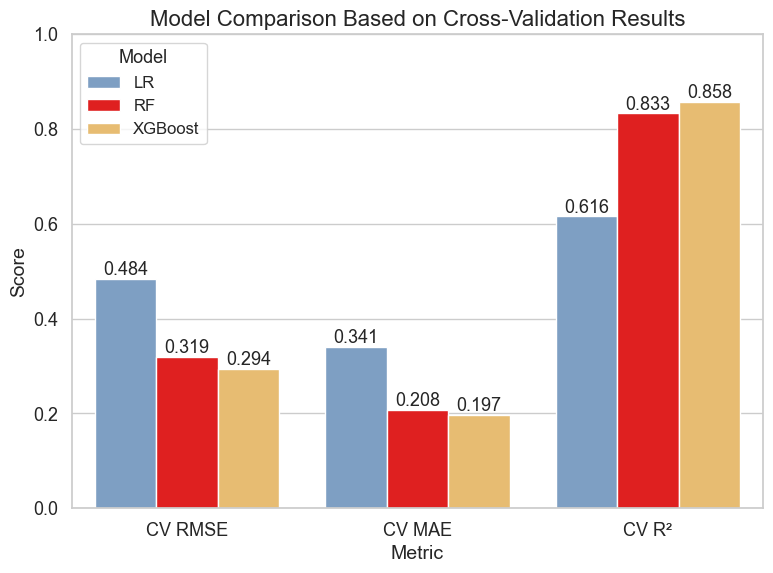

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# CV metrics data
metrics = ['CV RMSE', 'CV MAE', 'CV R²']
lr_scores = [0.4838, 0.3409, 0.6157]
rf_scores = [0.3188, 0.2077, 0.833]
xgb_scores = [0.2940, 0.1973, 0.858]

# create DataFrame
df = pd.DataFrame({
    'Metric': metrics * 3,
    'Score': lr_scores + rf_scores + xgb_scores,
    'Model': ['LR'] * 3 + ['RF'] * 3 + ['XGBoost'] * 3
})

# set colour
model_colors = {'LR': '#729ECE', 'RF': 'red', 'XGBoost': '#FBC15E'}

sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Metric', y='Score', hue='Model', data=df,
                      palette=model_colors)

# add values to bars
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.3f}', 
                     (p.get_x() + p.get_width() / 2, height), 
                     ha='center', va='bottom', fontsize=13)

# visulisation
plt.title('Model Comparison Based on Cross-Validation Results', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(title='Model', loc='upper left', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

# 4. Best Model Test Performance

In [37]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

# evaluate model performance in test set
y_pred_log = xgb_best.predict(X_test)

r2_log = r2_score(y_test, y_pred_log)
rmse_log = root_mean_squared_error(y_test, y_pred_log)
mae_log = mean_absolute_error(y_test, y_pred_log)

# model performance in original house price level
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred_log)

rmse_actual = root_mean_squared_error(y_test_actual, y_pred_actual)
mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"R² (log space): {r2_log:.4f}")
print(f"RMSE (log space): {rmse_log:.4f}")
print(f"MAE (log space): {mae_log:.4f}")
print(f"RMSE (actual house price): {rmse_actual:.4f} JPY")
print(f"MAE (actual house price): {mae_actual:.4f} JPY")

R² (log space): 0.8512
RMSE (log space): 0.2965
MAE (log space): 0.1978
RMSE (actual house price): 99489185.4110 JPY
MAE (actual house price): 16621123.4095 JPY


In [38]:
xgb_best.feature_importances_

array([0.0513493 , 0.0084983 , 0.29056427, 0.06424243, 0.01451322,
       0.05411033, 0.02097654, 0.01348029, 0.00874453, 0.        ,
       0.01346766, 0.04448482, 0.04186383, 0.00948038, 0.01491159,
       0.01997238, 0.0099894 , 0.01527935, 0.29162738, 0.01244398],
      dtype=float32)

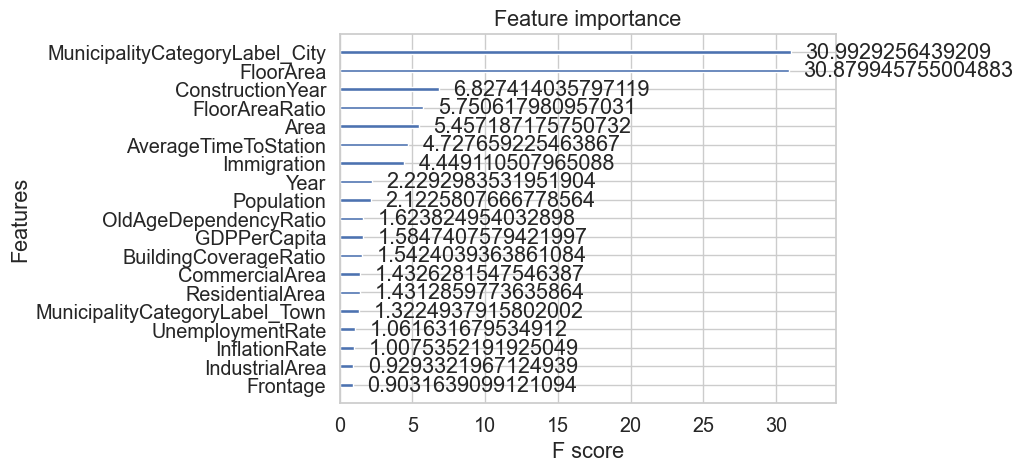

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_best, importance_type='gain') 
plt.show()

In [40]:
import shap

In [ ]:
# create a SHAP explainer object for XGBoost model (best model)
explainer = shap.Explainer(xgb_best)

# calculate SHAP values
shap_values = explainer(X)

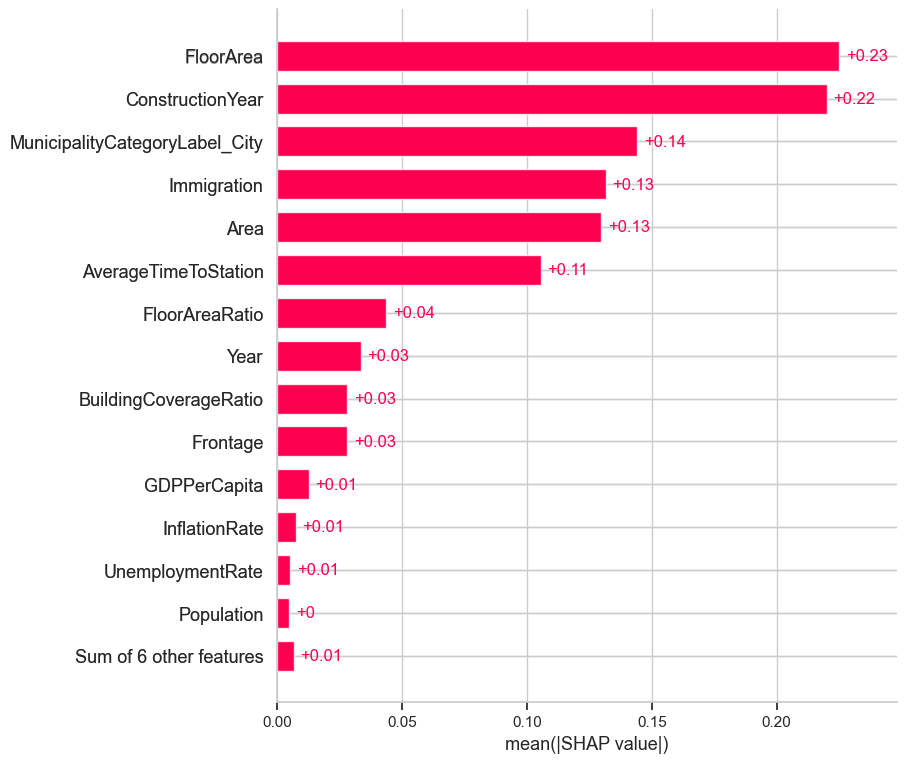

In [42]:
shap.plots.bar(shap_values, max_display = 15)

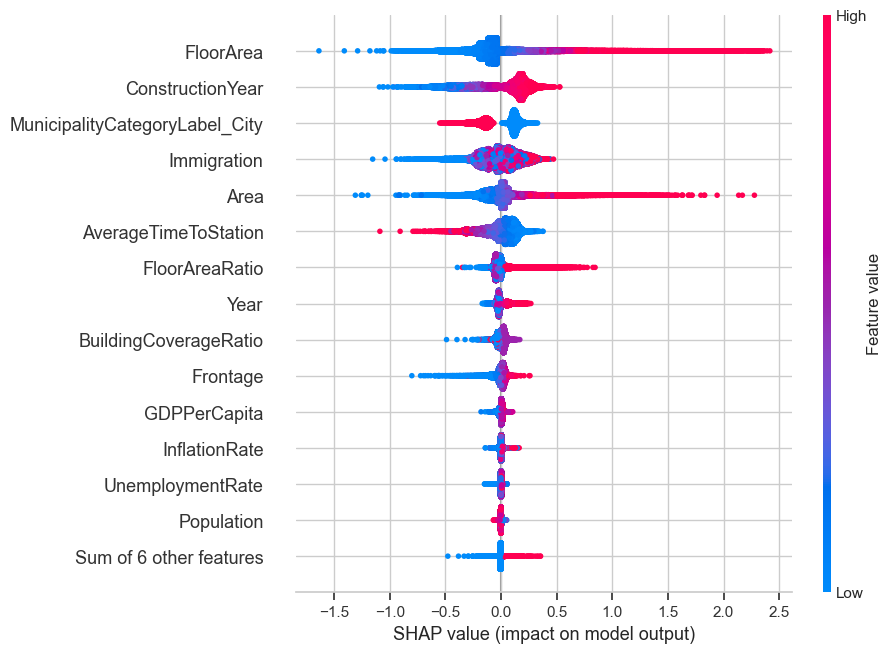

In [49]:
shap.plots.beeswarm(shap_values, max_display = 15)

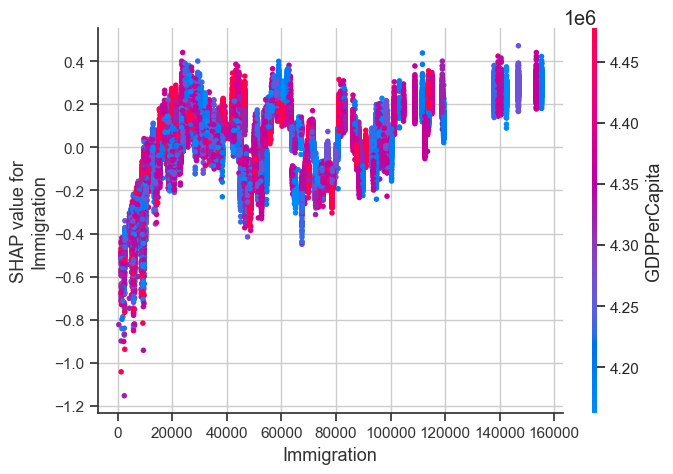

In [ ]:
shap.dependence_plot("Immigration", shap_values.values, X)